# 비트코인 가격 예측 및 시각화

In [2]:
import matplotlib.pyplot as plt
import requests
from datetime import datetime
import time
import pandas as pd
from tqdm import tqdm
import pymysql
from prophet import Prophet
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

In [3]:
# 그래프 스타일 설정
plt.style.use("ggplot")

In [4]:
# 그래프 한글 폰트 설정 (default : 영어, 한글 출력안됨)
plt.rcParams['font.family'] = 'Malgun Gothic'

In [5]:
# DB 연결
db = pymysql.connect(
    host='localhost',
    port=3306,
    user='root',
    passwd='8489',
    db='coin_db',
    charset='utf8'
)

In [16]:
sql = "SELECT open_time as ds, close_price as y FROM coin;"

bitcoin_df = pd.read_sql(sql, db)

C:\Users\Playdata\AppData\Local\Temp\ipykernel_19472\3779558273.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  bitcoin_df = pd.read_sql(sql, db)


In [17]:
# bitcoin_df

In [18]:
bitcoin_df.shape

(16550, 2)

In [19]:
bitcoin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16550 entries, 0 to 16549
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      16550 non-null  datetime64[ns]
 1   y       16550 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 258.7 KB


In [20]:
bitcoin_df.set_index('ds',inplace=True)
bitcoin_df.describe()

,y
count,16550.000000
mean,26659.826997
std,281.153418
min,26023.160000
25%,26527.105000
50%,26584.910000
75%,26756.030000
max,27477.000000


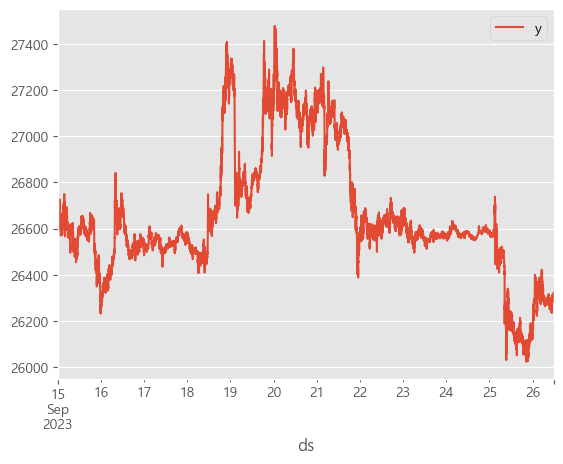

In [22]:
# 비트코인 시세 시각화
bitcoin_df.plot()
plt.show()

In [23]:
# 인덱스 삭제
bitcoin_df.reset_index(inplace=True)
bitcoin_df

,ds,y
0,2023-09-15 00:00:00,26699.99
1,2023-09-15 00:01:00,26677.36
2,2023-09-15 00:02:00,26696.84
3,2023-09-15 00:03:00,26697.46
4,2023-09-15 00:04:00,26661.38
...,...,...
16545,2023-09-26 11:45:00,26311.87
16546,2023-09-26 11:46:00,26311.88
16547,2023-09-26 11:47:00,26311.87
16548,2023-09-26 11:48:00,26311.87


In [24]:
# prophet 의 input data columns 는 'ds'와 'y'로 고정되어야 한다.
## seasonality_mode : 연간, 월간, 주간, 일간 등의 트렌드성을 반영하는 것을 의미
### changepoint_prior_scale : 트렌드가 변경되는 문맥을 반영하여 예측, 수치가 높을수록 트렌드를 더 반영
### 비트코인의 데이터의 경우, 대부분의 주기마다 트렌드성이 반영되는 것이 좋다.
prophet = Prophet(
    seasonality_mode='multiplicative', # 트렌드 반영
    yearly_seasonality=True, # 연간 트렌드
    weekly_seasonality=True, # 주간 트렌드
    daily_seasonality=True, # 일간 트렌드
    changepoint_prior_scale=0.5 # 트렌드 반영 비율
)

In [25]:
# 예측하기 위해 기존 데이터 파악
prophet.fit(bitcoin_df)

15:08:30 - cmdstanpy - INFO - Chain [1] start processing
15:08:45 - cmdstanpy - INFO - Chain [1] done processing


In [26]:
# 1분씩 데이터 60개 (60분) 예측하도록 설정
future_data = prophet.make_future_dataframe(periods=60, freq='min')

In [27]:
# 비트코인 가격 예측
forecast_data = prophet.predict(future_data)

In [28]:
# 예측한 60분 데이터 조회
## 비트코인 가격이 없는 순수한 예측값
forecast_data.tail(60)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
16550,2023-09-26 11:50:00,14130.363803,26293.647342,26461.561637,14130.363803,14130.363803,-0.004540,-0.004540,-0.004540,0.866862,...,-0.060397,-0.060397,-0.060397,0.931798,0.931798,0.931798,0.0,0.0,0.0,26379.432951
16551,2023-09-26 11:51:00,14130.708777,26295.208212,26462.570885,14130.708777,14130.708777,-0.004538,-0.004538,-0.004538,0.866869,...,-0.060348,-0.060348,-0.060348,0.931755,0.931755,0.931755,0.0,0.0,0.0,26380.179143
16552,2023-09-26 11:52:00,14131.053752,26295.349302,26461.089566,14131.053752,14131.053752,-0.004537,-0.004537,-0.004537,0.866876,...,-0.060300,-0.060300,-0.060300,0.931713,0.931713,0.931713,0.0,0.0,0.0,26380.928263
16553,2023-09-26 11:53:00,14131.398727,26300.907998,26467.660845,14131.398727,14131.398727,-0.004535,-0.004535,-0.004535,0.866884,...,-0.060252,-0.060252,-0.060252,0.931670,0.931670,0.931670,0.0,0.0,0.0,26381.680236
16554,2023-09-26 11:54:00,14131.743702,26298.581228,26464.108648,14131.743702,14131.743702,-0.004533,-0.004533,-0.004533,0.866892,...,-0.060203,-0.060203,-0.060203,0.931628,0.931628,0.931628,0.0,0.0,0.0,26382.434987
16555,2023-09-26 11:55:00,14132.088676,26301.704950,26468.750526,14132.088676,14132.088676,-0.004531,-0.004531,-0.004531,0.866900,...,-0.060155,-0.060155,-0.060155,0.931585,0.931585,0.931585,0.0,0.0,0.0,26383.192440
16556,2023-09-26 11:56:00,14132.433651,26298.991475,26462.824024,14132.433651,14132.433651,-0.004529,-0.004529,-0.004529,0.866908,...,-0.060106,-0.060106,-0.060106,0.931543,0.931543,0.931543,0.0,0.0,0.0,26383.952518
16557,2023-09-26 11:57:00,14132.778626,26302.273423,26466.735085,14132.778626,14132.778626,-0.004526,-0.004526,-0.004526,0.866916,...,-0.060058,-0.060058,-0.060058,0.931500,0.931500,0.931500,0.0,0.0,0.0,26384.715145
16558,2023-09-26 11:58:00,14133.123600,26300.346521,26467.891755,14133.123600,14133.123600,-0.004524,-0.004524,-0.004524,0.866925,...,-0.060009,-0.060009,-0.060009,0.931458,0.931458,0.931458,0.0,0.0,0.0,26385.480243
16559,2023-09-26 11:59:00,14133.468575,26301.673321,26465.476960,14133.468575,14133.468575,-0.004521,-0.004521,-0.004521,0.866934,...,-0.059960,-0.059960,-0.059960,0.931415,0.931415,0.931415,0.0,0.0,0.0,26386.247735


In [29]:
# 예측값 조회
# ds : 날짜와 시간
# yhat : 예측값
# yhat_lower : 예측값의 최저
# yhat_upper : 예측값의 최고
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(60)

,ds,yhat,yhat_lower,yhat_upper
16550,2023-09-26 11:50:00,26379.432951,26293.647342,26461.561637
16551,2023-09-26 11:51:00,26380.179143,26295.208212,26462.570885
16552,2023-09-26 11:52:00,26380.928263,26295.349302,26461.089566
16553,2023-09-26 11:53:00,26381.680236,26300.907998,26467.660845
16554,2023-09-26 11:54:00,26382.434987,26298.581228,26464.108648
16555,2023-09-26 11:55:00,26383.192440,26301.704950,26468.750526
16556,2023-09-26 11:56:00,26383.952518,26298.991475,26462.824024
16557,2023-09-26 11:57:00,26384.715145,26302.273423,26466.735085
16558,2023-09-26 11:58:00,26385.480243,26300.346521,26467.891755
16559,2023-09-26 11:59:00,26386.247735,26301.673321,26465.476960


c:\Users\Playdata\anaconda3\envs\bigdata_env\lib\site-packages\prophet\plot.py:71: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\Playdata\anaconda3\envs\bigdata_env\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


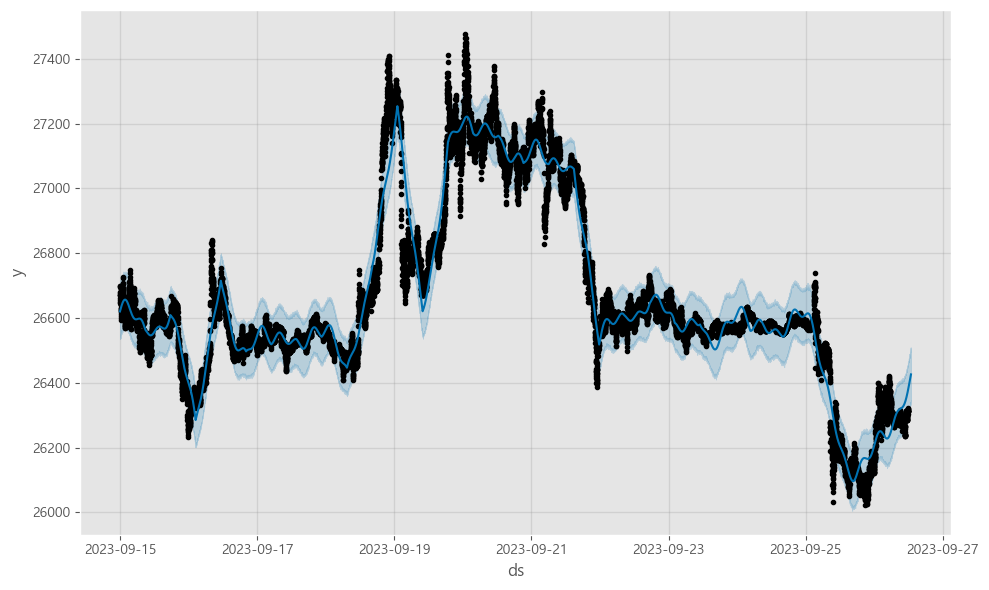

In [30]:
# 예측값 시각화
fig1 = prophet.plot(forecast_data)

c:\Users\Playdata\anaconda3\envs\bigdata_env\lib\site-packages\prophet\plot.py:226: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\Playdata\anaconda3\envs\bigdata_env\lib\site-packages\prophet\plot.py:395: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
c:\Users\Playdata\anaconda3\envs\bigdata_env\lib\site-packages\prophet\plot.py:399: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime o

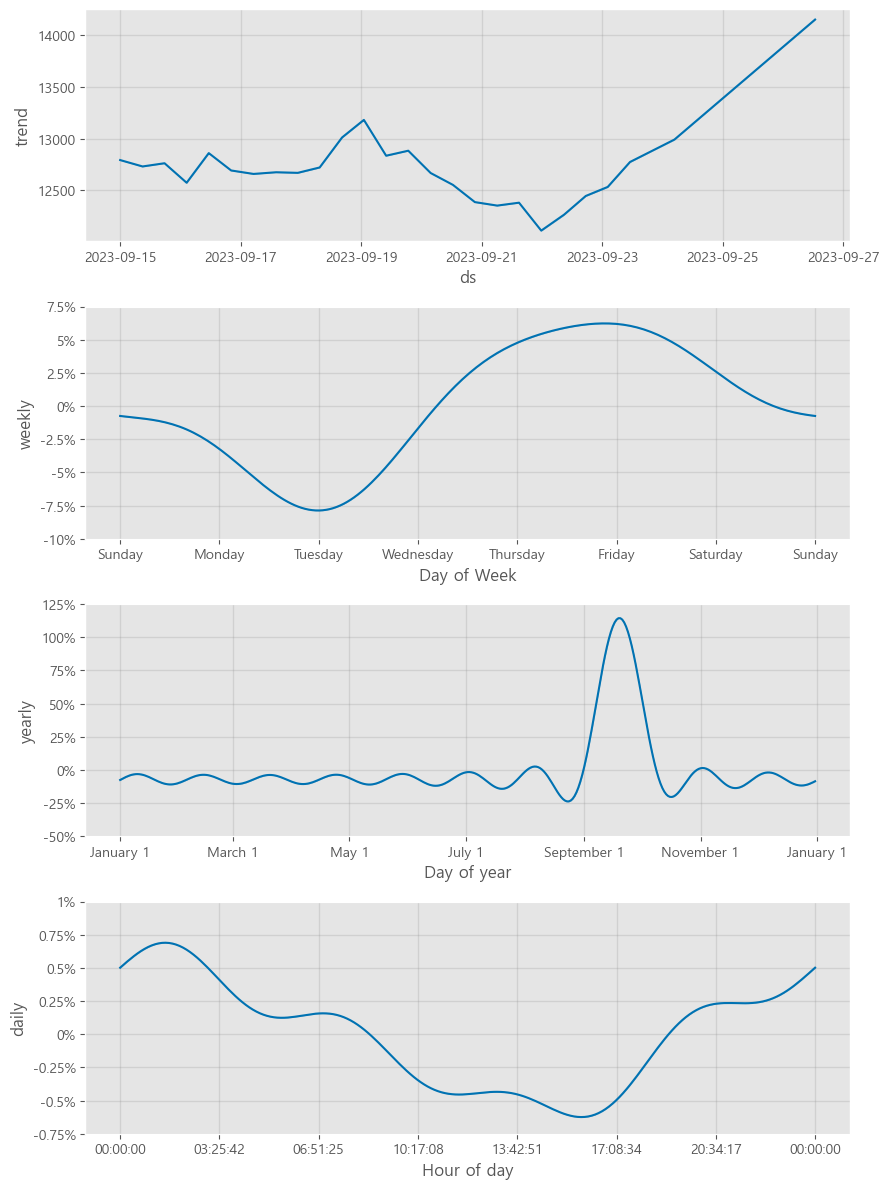

In [31]:
# seasonality_mode 로 설정했었던 기간별 트렌드 정보를 시각화
fig2 = prophet.plot_components(forecast_data)

In [32]:
# 예측값 리턴
pred_y= forecast_data.yhat.values
# 비트코인 실제 가격 리턴
test_y= bitcoin_df.y.values
# 예측 하한값 리턴
pred_y_lower= forecast_data.yhat_lower.values
# 예측 상한값 리턴
pred_y_upper= forecast_data.yhat_upper.values

In [33]:
# pred_y[:-60] : 마지막 60개를 제외한 예측값 (마지막 1시간은 없음)
# test_y : 실제 비트코인 가격
# 실제가격과 예측값 차이의 평균 계산
rmse=sqrt(mean_squared_error(test_y,pred_y[:-60]))
print(rmse)

64.49564453226586


In [34]:
# 예측의 정확성
r2_score(test_y, pred_y[:-60]) # 94% 정도의 정확성

0.9473740098526398

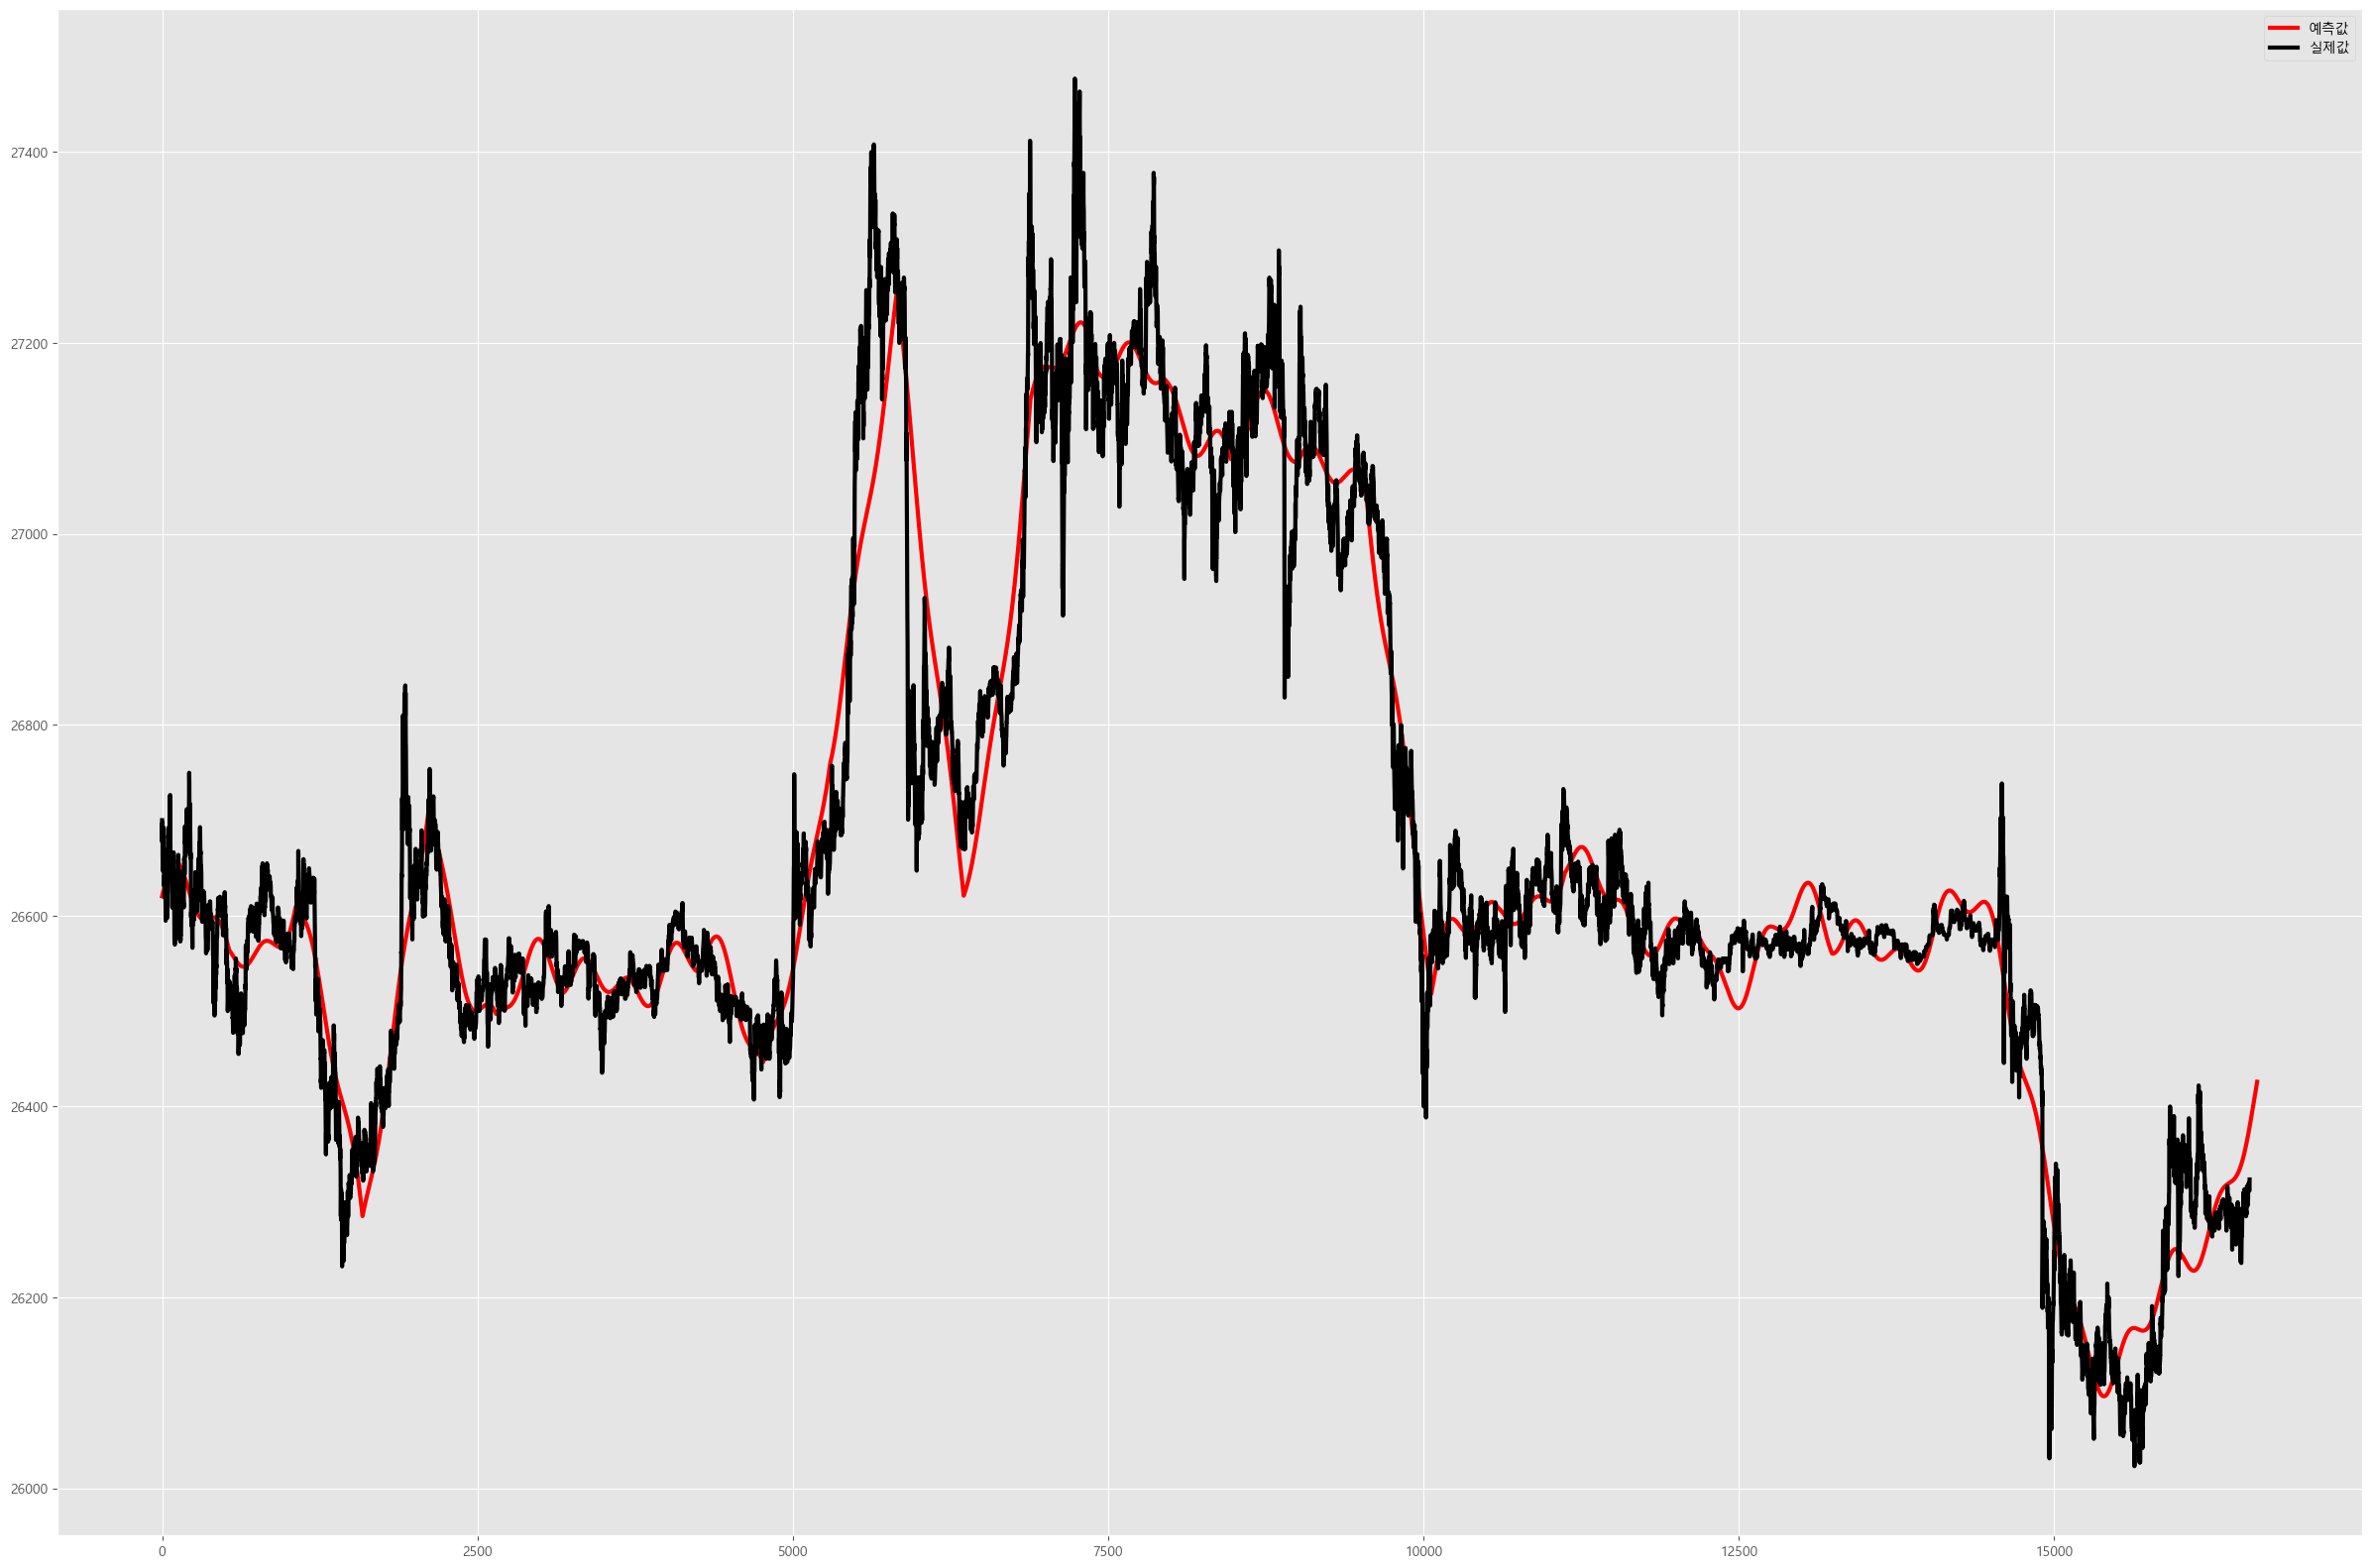

In [35]:
# 그래프 가로30 세로20
plt.figure(figsize=(30,20))
plt.plot(pred_y, color="red", label="예측값", linewidth=3.0) # 모델이 예상한 그래프
plt.plot(test_y, color="black", label="실제값", linewidth=3.0) # 실제 가격 그래프
plt.legend() # 범례 출력

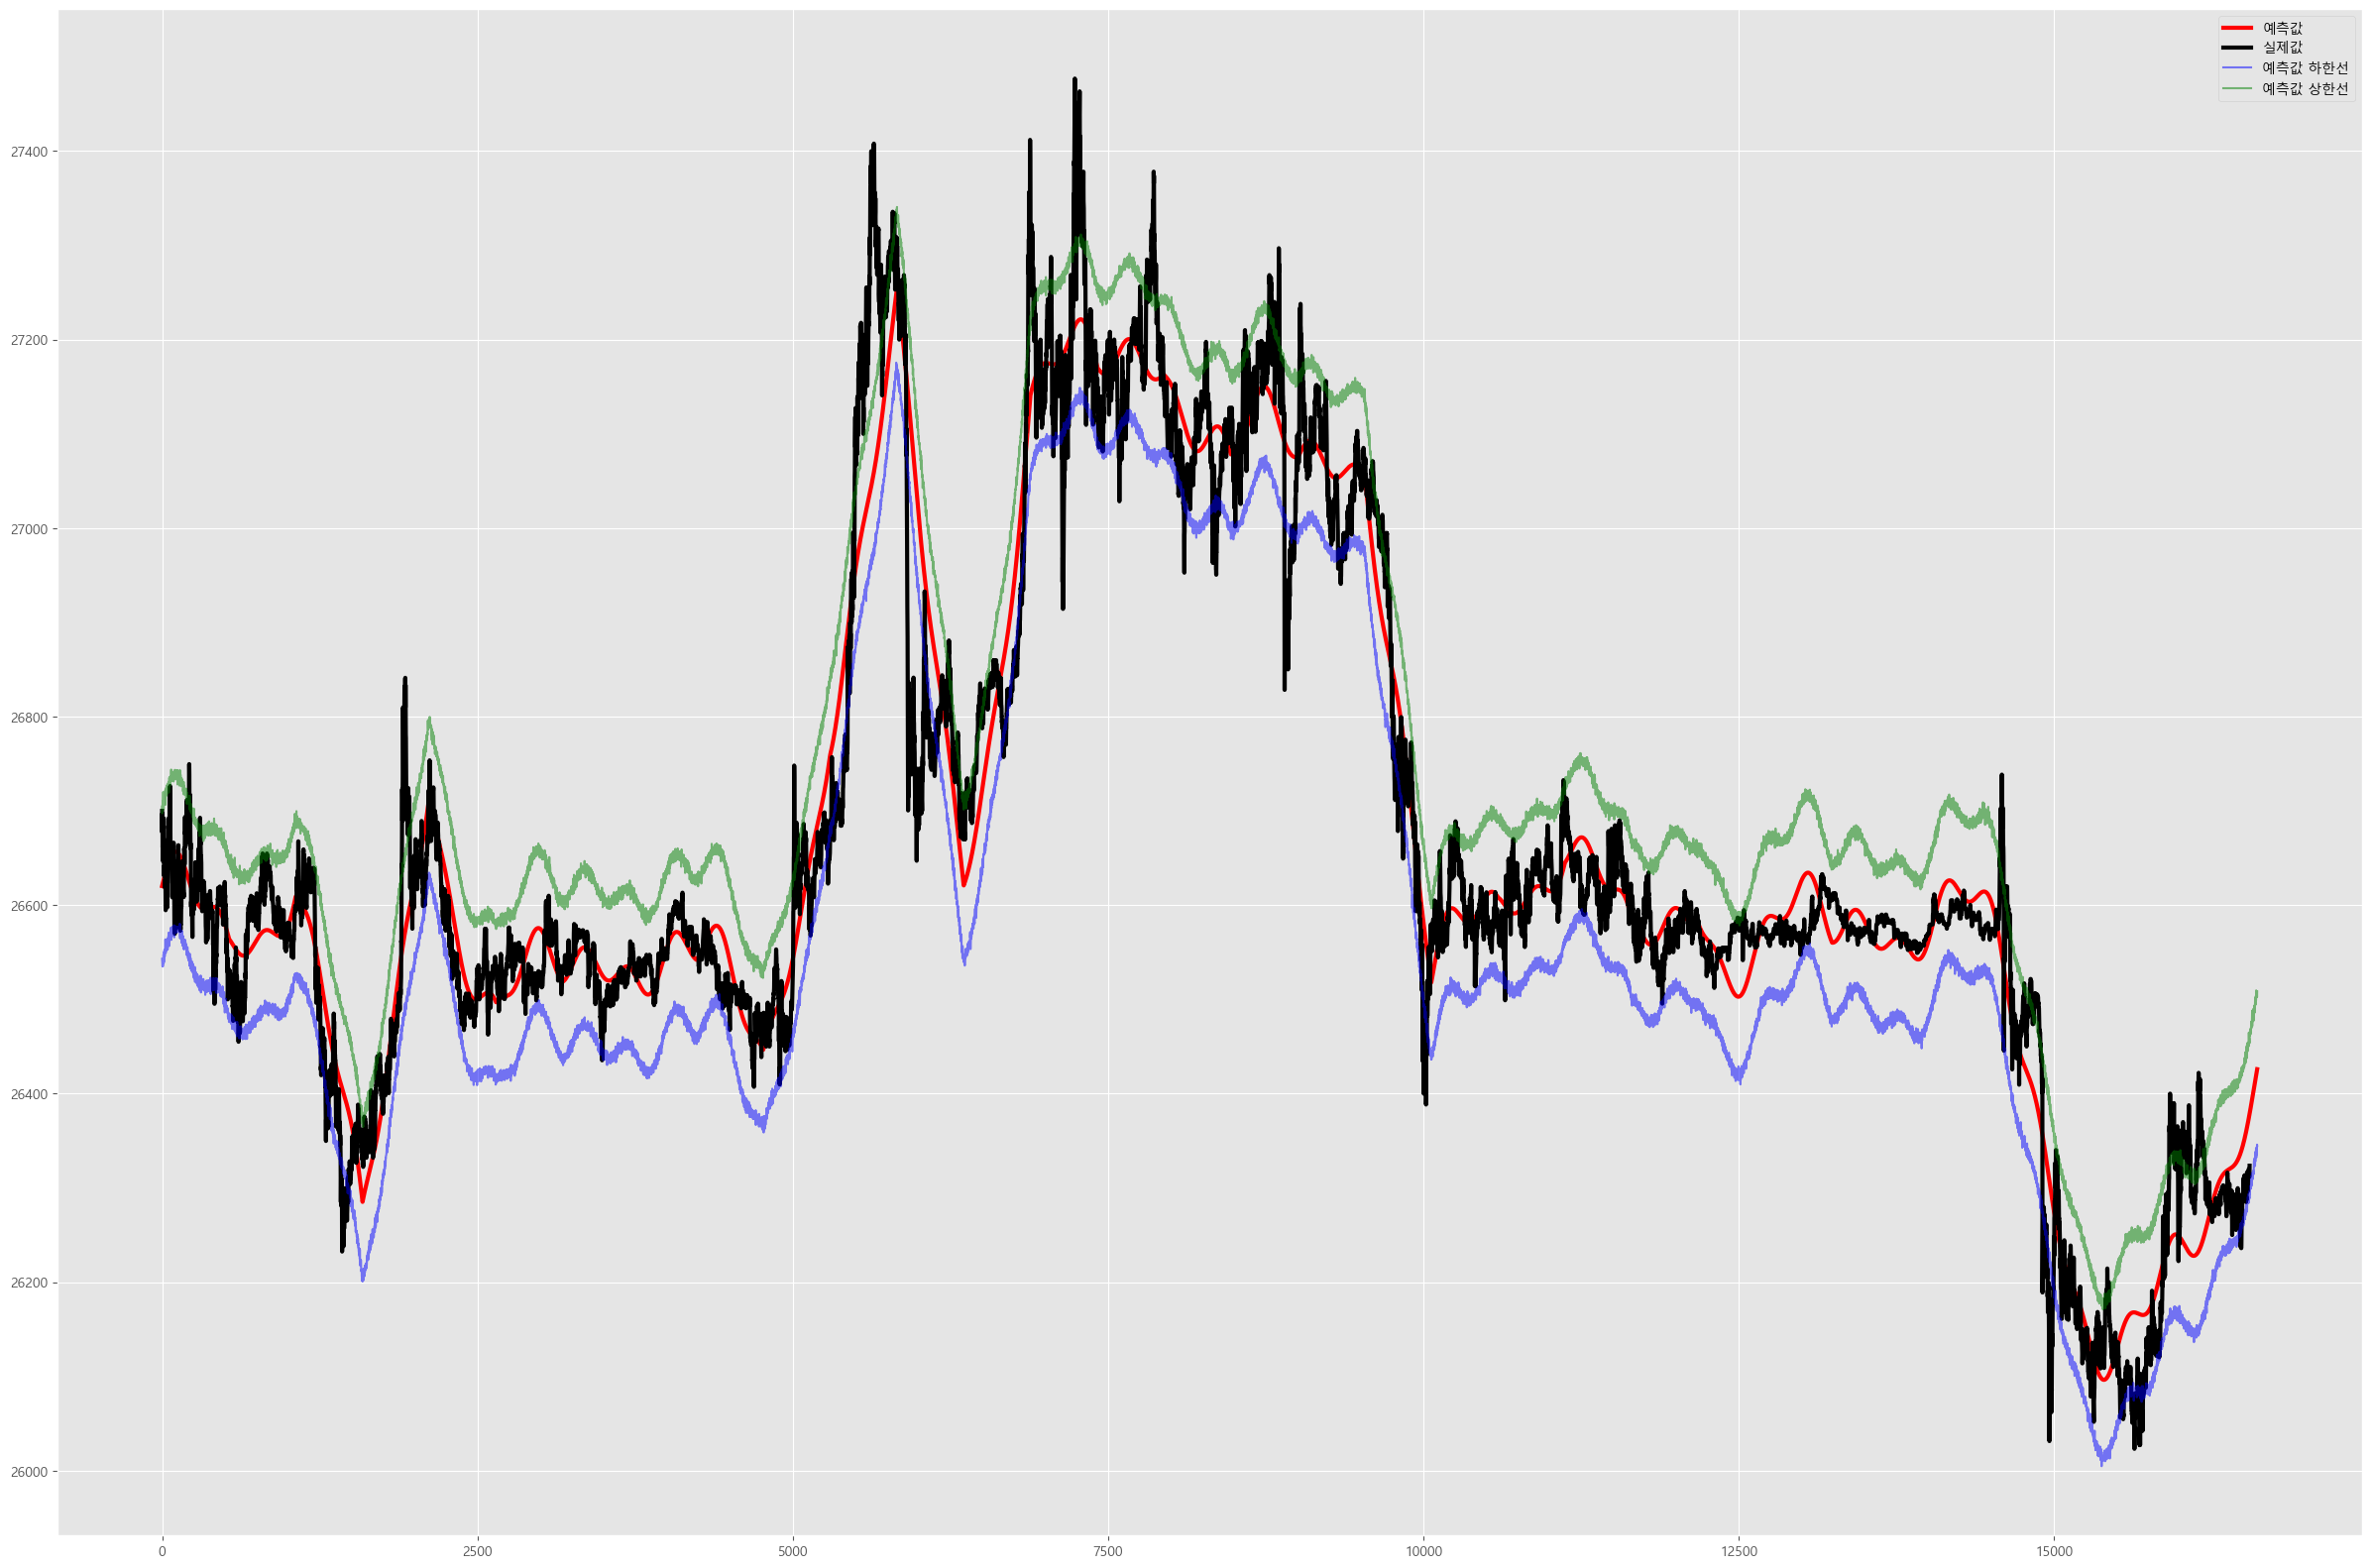

In [37]:
# 그래프 가로30 세로20
plt.figure(figsize=(30,20))
plt.plot(pred_y, color="red", label="예측값", linewidth=3.0) # 모델이 예상한 그래프
plt.plot(test_y, color="black", label="실제값", linewidth=3.0) # 실제 가격 그래프
plt.plot(pred_y_lower, color="blue", label="예측값 하한선", alpha=0.5) # 예측 하한선 그래프
plt.plot(pred_y_upper, color="green", label="예측값 상한선", alpha=0.5) # 예측 상한선 그래프
plt.legend() # 범례 출력

In [39]:
len(bitcoin_df)
df_count=len(bitcoin_df)

In [40]:
cursor=db.cursor()

In [42]:
bitcoin_df.loc[i,"ds"]

Timestamp('2023-09-15 00:00:00')

In [45]:
forecast_data.loc[i,"ds"]

Timestamp('2023-09-15 00:00:00')

In [51]:
for i in tqdm(range(df_count)):
    # 실제 비트코인 가격 정보가 저장된 bitcoin_df 의 index 행 ds 열의 데이터 리턴
    open_date = bitcoin_df.loc[i,"ds"]

    # 예측값이 저장된 forecast_data 의 index 행 ds 열의 데이터 리턴
    predict_price = forecast_data.loc[i,"yhat"]

    # coin 테이블에 예측값을 넣는 쿼리, 기존 null 값, update 사용
    sql = 'update coin set predic_price=%s where open_time=%s'
    
    cursor.execute(sql,(predict_price, open_date))
    db.commit()
    
print("삽입 완료")

100%|██████████| 16550/16550 [02:50<00:00, 96.80it/s] 

삽입 완료


In [52]:
db.close()